In [1]:
import sys
sys.path

['/home/nastya/jupyter/anomalies',
 '/snap/jupyter/6/lib/python37.zip',
 '/snap/jupyter/6/lib/python3.7',
 '/snap/jupyter/6/lib/python3.7/lib-dynload',
 '',
 '/home/nastya/snap/jupyter/common/lib/python3.7/site-packages',
 '/snap/jupyter/6/lib/python3.7/site-packages',
 '/snap/jupyter/6/lib/python3.7/site-packages/IPython/extensions',
 '/home/nastya/snap/jupyter/6/.ipython']

In [2]:
sys.path.append('/home/nastya/anaconda3/lib/python3.7/site-packages')

In [3]:
sys.path

['/home/nastya/jupyter/anomalies',
 '/snap/jupyter/6/lib/python37.zip',
 '/snap/jupyter/6/lib/python3.7',
 '/snap/jupyter/6/lib/python3.7/lib-dynload',
 '',
 '/home/nastya/snap/jupyter/common/lib/python3.7/site-packages',
 '/snap/jupyter/6/lib/python3.7/site-packages',
 '/snap/jupyter/6/lib/python3.7/site-packages/IPython/extensions',
 '/home/nastya/snap/jupyter/6/.ipython',
 '/home/nastya/anaconda3/lib/python3.7/site-packages']

In [4]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

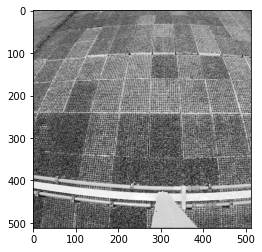

In [5]:
from matplotlib import pyplot
ref_img=Image.open('frames/square_frame02941.png').convert("L")
pyplot.imshow(ref_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

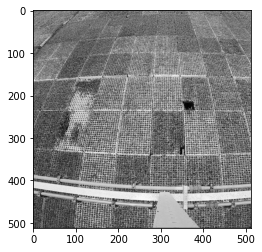

In [6]:
anomalous_img=Image.open('frames/square_frame01981.png').convert("L")
pyplot.imshow(anomalous_img, cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [7]:
import numpy as np
anomalous = np.array(anomalous_img)
reference  = np.array(ref_img)

In [8]:
anomalous.shape

(512, 512)

In [9]:
reference.shape

(512, 512)

In [10]:
anomalous

array([[126, 143, 116, ..., 115, 130, 141],
       [ 96, 132, 160, ..., 114, 126, 125],
       [122, 133, 136, ..., 104, 150, 128],
       ...,
       [ 65,  63,  91, ...,  33,  44,  61],
       [ 74, 102,  43, ...,  25,  20,  32],
       [ 57,  56,  37, ...,  10,  16,  22]], dtype=uint8)

In [11]:
reference

array([[152, 147, 132, ...,  46,  33,  19],
       [123, 131, 125, ...,  53,  58,  30],
       [157, 145, 160, ...,  89,  89,  76],
       ...,
       [ 31,  75,  76, ..., 107,  82, 100],
       [ 79,  66,  63, ..., 137, 137, 125],
       [ 38,  35,  41, ...,  32,  71,  74]], dtype=uint8)

In [12]:
# Выделяет из картинки патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Патчи не накладываются
def generate_points(matrix, sp):
    points = []
    for i in range(0, matrix.shape[0], sp):
        for j in range(0, matrix.shape[1], sp):
            point = matrix[i:i+sp, j:j+sp]
            point = point.flatten()
            points.append(point)
    return points

In [13]:
#Проверка generate_points
a = np.array([[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])
generate_points(a, 2)

[array([1, 2, 5, 3]),
 array([0, 0, 0, 4]),
 array([0, 0, 9, 3]),
 array([0, 7, 0, 0])]

In [14]:
# Выделяет из картинки патчи размером sp, линеаризует и возвращает набор этих векторов (точки пространства)
# Патчи накладываются
def generate_points_overlay(matrix, sp):
    points = []
    for i in range(0, matrix.shape[0] - sp + 1):
        for j in range(0, matrix.shape[1] - sp + 1):
            point = matrix[i:i+sp, j:j+sp]
            point = point.flatten()
            points.append(point)
#             point_np = np.array(point)
#             point_reshaped = np.reshape(point_np, (sp,sp))
#             img = Image.fromarray(point_reshaped, 'L')
#             pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
#             pyplot.show()
            
    return points

In [15]:
#Проверка generate_points_overlay
arr = np.array([[1, 2, 0, 0, 1],
              [5, 3, 0, 4, 2],
              [0, 0, 0, 7, 9],
              [9, 3, 0, 0, 10]])
p = generate_points_overlay(arr, 3)
p

[array([1, 2, 0, 5, 3, 0, 0, 0, 0]),
 array([2, 0, 0, 3, 0, 4, 0, 0, 7]),
 array([0, 0, 1, 0, 4, 2, 0, 7, 9]),
 array([5, 3, 0, 0, 0, 0, 9, 3, 0]),
 array([3, 0, 4, 0, 0, 7, 3, 0, 0]),
 array([ 0,  4,  2,  0,  7,  9,  0,  0, 10])]

In [16]:
b = np.array([0,1,2,3])
b.shape
b = np.reshape(b, (2, 2))
b

array([[0, 1],
       [2, 3]])

In [17]:
from scipy.ndimage import convolve

In [18]:
# Проверка convolve
a = np.array([[1, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])
k = np.array([[1,1,1],[1,1,0],[1,0,0]])
convolve(a, k, mode='constant', cval=0.0)

array([[11, 10,  7,  4],
       [10,  3, 11, 11],
       [15, 12, 14,  7],
       [12,  3,  7,  0]])

In [19]:
from scipy.ndimage import gaussian_filter 
import scipy.stats as st
import skimage.measure

In [20]:
# Возвращает 2D гауссово ядро
def gaussian_kern(dimension, sigma=1.39):
    x = cv2.getGaussianKernel(dimension,sigma)
    y = cv2.getGaussianKernel(dimension, sigma)
    kernel = x.dot(y.T)
    return kernel

In [21]:
# Пример ядра
gaussian_kern(5, 1)

array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]])

In [22]:
# Пример ядра
gaussian_kern(5)

array([[0.01191142, 0.02588995, 0.03353671, 0.02588995, 0.01191142],
       [0.02588995, 0.05627285, 0.07289339, 0.05627285, 0.02588995],
       [0.03353671, 0.07289339, 0.09442291, 0.07289339, 0.03353671],
       [0.02588995, 0.05627285, 0.07289339, 0.05627285, 0.02588995],
       [0.01191142, 0.02588995, 0.03353671, 0.02588995, 0.01191142]])

In [23]:
# Возвращает кортеж из 4 картинок разных масштабов
def multiscale_decomposition(u, v):
    sigma = 1.39 # Чему равна сигма?
    kernlen = 13 # Зависит от того что такое сигма
    gauss = gaussian_kern(kernlen)
    u0 = u
    v0 = v
    
    u1 = convolve(u0, gauss)
    u1 = skimage.measure.block_reduce(u1, (2,2), np.max)
    v1 = convolve(v0, gauss)
    v1 = skimage.measure.block_reduce(v1, (2,2), np.max)
    
    u2 = convolve(u1, gauss)
    u2 = skimage.measure.block_reduce(u2, (2,2), np.max)
    v2 = convolve(v1, gauss)
    v2 = skimage.measure.block_reduce(v2, (2,2), np.max)
    
    u3 = convolve(u2, gauss)
    u3 = skimage.measure.block_reduce(u3, (2,2), np.max)
    v3 = convolve(v2, gauss)
    v3 = skimage.measure.block_reduce(v3, (2,2), np.max)
    return (u0, u1, u2, u3, v0, v1, v2, v3)

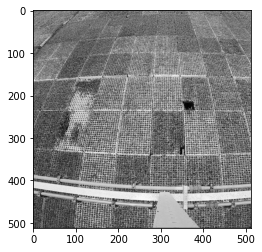

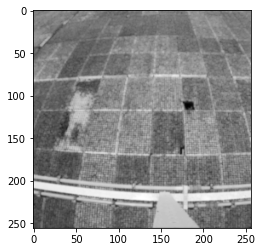

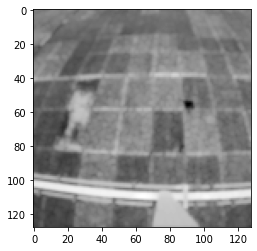

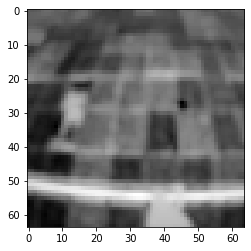

In [24]:
# Проверка multiscale_decomposition
u_0, u_1, u_2, u_3, v_0, v_1, v_2, v_3 = multiscale_decomposition(anomalous, reference)
i = 0
for u in (u_0, u_1, u_2, u_3):
    img = Image.fromarray(u, 'L')
    pyplot.imshow(img, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    name = "scale" + str(i)
    img.save(name, format="png")
    i = i + 1

In [25]:
import vptree

In [26]:
#Евклидово расстояние
def euclidean(p1, p2):
  return np.sqrt(np.sum(np.power(p2 - p1, 2)))

In [27]:
a = np.array([1, 2, 3, 4])
b = np.array([[4, 5],[6, 7], [8, 9]])
a = np.reshape(a,(1, 4))
b = np.reshape(b,(3, 2))
c = [(1, 2), (3, 4), (5, 6)]
a = np.reshape(a,(2,2))
a

array([[1, 2],
       [3, 4]])

In [28]:
import math

In [40]:
# реконструированный патч
def reconstruct(dist, patches, n, h, sp):
    denominator = 0.0
    nomenator = np.zeros((1, sp*sp))
    for i in range(0,n):
        patch = patches[i][:]
        patch = np.reshape(patch, (1,sp*sp))
        nomenator = nomenator + patch * math.exp(-(float(dist[i]) ** 2)/(h * h))
        
        denominator = denominator + math.exp(-(float(dist[i]) ** 2)/(h * h))
    result = nomenator / denominator # размер (1, sp^2)
#     result_im = np.reshape(result, (sp,sp))
#     img = Image.fromarray(result_im, 'L')
#     pyplot.imshow(result_im, cmap=pyplot.get_cmap('gray'))
#     pyplot.show()
    return result

In [101]:
# Собирает из накладывающихся патчей картинку
def image_from_patches(patches, u_width, u_height, sp):
    image = np.zeros((u_height, u_width))
    k = 0;
    for i in range(0, u_height, sp):
        for j in range(0, u_width, sp):
            patch = np.reshape(patches[k], (sp, sp))
            image[i:i+sp, j:j+sp] = patch
            k = k + 1
    return image


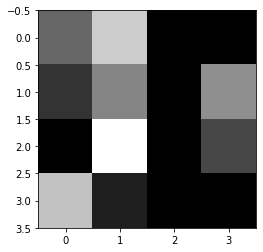

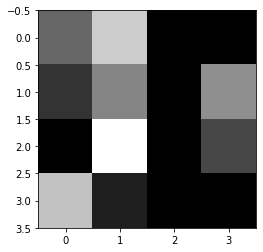

In [103]:
# Тест image_from_patches
image_test = np.array([[100, 200, 0, 0],
              [50, 130, 0, 140],
              [0, 250, 0, 70],
              [190, 30, 0, 0]])
enc_img = Image.fromarray(image_test, 'L')
pyplot.imshow(image_test, cmap=pyplot.get_cmap('gray')) # рисую сразу массив
pyplot.show()

p = generate_points(image_test, 2) # генерируем патчи размера (2,2)

decoded_image = image_from_patches(p, image_test.shape[1], image_test.shape[0], 2) # восстанавливаем картинку по патчам
dec_img = Image.fromarray(decoded_image, 'L')
pyplot.imshow(decoded_image, cmap=pyplot.get_cmap('gray')) # рисую сразу массив
pyplot.show()

In [89]:
def get_u_model(patches, u_width, u_height, sp):
    u_model = np.zeros((u_height, u_width))
    #print(len(patches))
    k = 0
    for i in range(u_height - sp + 1):
        for j in range(u_width - sp + 1):
            #print(k)
            patch = np.reshape(patches[k], (sp, sp))
            u_model[i:i+sp, j:j+sp] += patch
            k = k + 1
    for i in range(u_height):
        for j in range(u_width):
            u_model[i][j] /= (min(i+1, u_height-i, sp) * min(j+1, u_width-j, sp))
    return u_model

In [90]:
a = np.array([[1, 2, 0, 0, 1],
              [5, 3, 0, 4, 1],
              [0, 0, 0, 7, 1],
              [9, 3, 0, 0, 1]])
points_a = generate_points_overlay(a, 2)
get_u_model(points_a, 5, 4, 2)

array([[1., 2., 0., 0., 1.],
       [5., 3., 0., 4., 1.],
       [0., 0., 0., 7., 1.],
       [9., 3., 0., 0., 1.]])

In [94]:
# С усреднением наложившихся патчей
def compute_residual(u, v, n, h, sp):
    points_u = generate_points_overlay(u, sp)
    points_v = generate_points_overlay(v, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(points_v, euclidean)
    i = 0
    for patch in points_u:
        
        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #patch_reconstr = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    #u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

In [98]:
# Без усреднения и без наложения патчей
def compute_residual_not_overlay(u, v, n, h, sp):
    points_u = generate_points(u, sp)
    points_v = generate_points(v, sp)
    num_of_points = len(points_u)
    print(num_of_points)
    reconstructed_patches = []
    tree = vptree.VPTree(points_v, euclidean)
    i = 0
    for patch in points_u:
        
        neighbors = tree.get_n_nearest_neighbors(patch, n) #Считаем что u никогда не равно v, возвращает список кортежей (расстояние, точка)
        if (len(neighbors) != n):
            extra_neighbor = neighbors[0]
            l = len(neighbors)
            for j in range(l, n):
                neighbors.append(extra_neighbor)
                #print(extra_neighbor)
        assert len(neighbors) == n
        dist = np.array([neighbor[0] for neighbor in neighbors])
        dist = np.reshape(dist, (len(neighbors), 1)) # размер (n, 1)
        patches = np.array([neighbor[1] for neighbor in neighbors]) # размер (n, sp^2)
        assert patches.shape == (n, sp*sp)
        
        #patch_reconstr = np.sum(np.exp(-(dist ** 2) / (h*h)) * patches, axis=0) / np.sum(np.exp(-(dist ** 2) / (h*h)))
        
        reconstructed_patch = reconstruct(dist, patches, n, h, sp)
        reconstructed_patches.append(reconstructed_patch)
        
    #u_model = get_u_model(reconstructed_patches, u.shape[1], u.shape[0], sp)
    u_model = image_from_patches(reconstructed_patches, u.shape[1], u.shape[0], sp)
    return u_model - u

3249


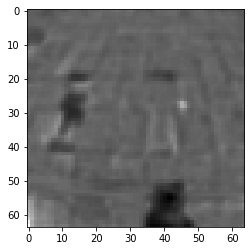

In [93]:
# С усреднением наложившихся патчей
residual = compute_residual(u_3, v_3, 16, 10, 8)
img = Image.fromarray(residual, 'L')
pyplot.imshow(residual, cmap=pyplot.get_cmap('gray'))
pyplot.show()

64


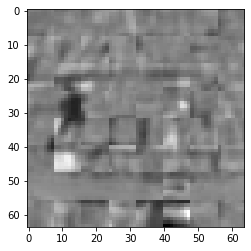

In [100]:
# Без наложения и без усреднения
residual = compute_residual_not_overlay(u_3, v_3, 16, 10, 8)
img = Image.fromarray(residual, 'L')
pyplot.imshow(residual, cmap=pyplot.get_cmap('gray'))
pyplot.show()

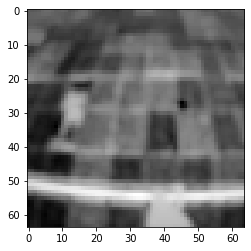

In [36]:
pyplot.imshow(u_3, cmap=pyplot.get_cmap('gray'))
pyplot.show()